In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import cv2
from functools import reduce
from moviepy.editor import ImageSequenceClip
from IPython.display import display, Image
import matplotlib.animation as animation
import matplotlib.patches as patches
import imageio
import os
import gc
from utils import labels2binary, kernel, seg_weights_2D
from scipy.ndimage import binary_fill_holes
import skimage.morphology as morph
from skimage.filters import sobel, gaussian
from skimage.measure import label

In [2]:
def reindex_cell_labels(img):
    idx = np.unique(img)
    img_c = img.copy()
    for i, x in enumerate(idx):
        img_c[img_c == x] = i
    return(img_c.astype('uint16'))

def custom_weights_1(I_s, sigma_gaussian = 0.8, n_rounds_gaussian=50, quant_filt = 0.85, final_power = 6):
    """
    Function to generate weights that highlight boarders between neighboring cells 
    Based principally on Sobel filter, gaussian blur and filtering high values
    """
    # First Sobel filtering to make cell boarders appear
    sob_s = sobel(I_s)
    
    # First we apply multiple rounds of gaussian blur
    for i in range(n_rounds_gaussian):
        sob_s += gaussian(sob_s, sigma=sigma_gaussian, preserve_range=True)

    # Second, we only keep highest values (tend to overrepresent intersection between cells)
    quant_threshold = np.quantile(sob_s[sob_s > 0], q=quant_filt)
    sob_s[sob_s < quant_threshold] = 0
    # We give pixel inside cells a minimum value
    cell_score = min(sob_s[sob_s > 0])
    sob_s[I_s == 1] += cell_score

    # We reverse the image and do similar filtering : This allow to improve signal on pixels between cells
    sob_s[sob_s > 0] = 1/sob_s[sob_s > 0]
    quant_threshold = np.quantile(sob_s[sob_s > 0], q=quant_filt)
    sob_s[sob_s > quant_threshold] = 0
    cell_score = min(sob_s[sob_s > 0])
    sob_s[I_s == 1] += cell_score
    
    # We reverse again to the original 
    sob_s[sob_s > 0] = 1/sob_s[sob_s > 0]

    # We expend to a power to exagerate differences 
    sob_s = sob_s**final_power
    
    # Normalize between 0 and 255
    sob_s = (sob_s - np.min(sob_s))/(np.max(sob_s) - np.min(sob_s)) * 255

    return(sob_s)

def rangescale(frame, rescale):
    '''
    Rescale image values to be within range

    Parameters
    ----------
    frame : ND numpy array of uint8/uint16/float/bool
        Input image(s).
    rescale : Tuple of 2 values
        Values range for the rescaled image.

    Returns
    -------
    2D numpy array of floats
        Rescaled image

    '''
    frame = frame.astype(np.float32)
    if np.ptp(frame) > 0:
        frame = ((frame-np.min(frame))/np.ptp(frame))*np.ptp(rescale)+rescale[0]
    else:
        frame = np.ones_like(frame)*(rescale[0]+rescale[1])/2
    return frame


def tracking_weights(track, segall, halo_distance = 50):
    '''
    Compute weights for tracking training sets

    Parameters
    ----------
    track : 2D array
        Tracking output mask.
    segall : 2D array
        Segmentation mask of all cells in current image.
    halo_distance : int, optional
        Distance in pixels to emphasize other cells from tracked cell.
        The default is 50.

    Returns
    -------
    weights : 2D array
        Tracking weights map.

    '''
    
    # Cell escaped / disappeared:
    if np.max(track)==0:
        weights = ((segall>0).astype(np.uint8)*20)+1
        return weights
    
    # Distance from the tracked cell:
    _, dist_from = morph.medial_axis(track==0,return_distance=True)
    dist_from = halo_distance-dist_from
    dist_from[dist_from<1] = 1
    
    # Distance from border within cell:
    _, dist_in = morph.medial_axis(track>0,return_distance=True)
    
    # Tracked cell skeleton:
    skel = morph.skeletonize(track,method='lee')
    
    # Tracked Cell weights are distance from edges + skeleton at 255 in the center
    weights = rangescale(dist_in+1,(1,42))
    weights[skel>0] = 255
    
    # Rest of the image is weighed according to distance from tracked cell:
    weights+= 63*(dist_from/halo_distance) \
        *(segall>0).astype(np.float32)\
            *(track==0).astype(np.float32)
    
    weights*=100
    weights[dist_from<1] = 1
        
    return weights

def reindex_cell_labels(img):
    idx = np.unique(img)
    img_c = img.copy()
    for i, x in enumerate(idx):
        img_c[img_c == x] = i
    return(img_c.astype('uint16'))

#### BUILD TRAINING SET FOR CELL TRACING (FROM MANUAL ANNOTATIONS)

In [26]:
# We load the raw images :
cell_img_file = "data/_fullmovie_images_2.tif"
_, cell_img = cv2.imreadmulti(cell_img_file, [], cv2.IMREAD_ANYDEPTH)
img = np.zeros((125,cell_img[0].shape[0],cell_img[0].shape[1])).astype('float32')
max_full_img = np.max(cell_img)
min_full_img = np.min(cell_img)
perc99_99 = np.quantile(cell_img, q=0.9999) # Use 99.99 percentile to roof image values

In [39]:
img_sub = np.zeros((125,500,500)).astype('float32')
idx=0
for i in range(len(cell_img)):
    I = cell_img[i].copy().astype('float32')
    I[I > perc99_99] = perc99_99 # roof value at 99.99% of full image (which becomes new max)
    I_norm = (I - min_full_img)/(max_full_img - min_full_img) # normalization accross all frames and all image
    img[i] = (I_norm.copy()*255).astype('uint8') # testing set [1024:1536, 0:512], training [0:512, 0:512]
    
    # Get output name
    out_name = "Sample0000" + str(i) + ".png"
    if idx > 9:
        out_name = "Sample000" + str(i) + ".png"
    if idx > 99:
        out_name = "Sample00" + str(i) + ".png"
    if idx > 999:
        out_name = "Sample0" + str(i) + ".png"
    if idx > 9999:
        out_name = "Sample" + str(i) + ".png"
                      
    cv2.imwrite('data/_fullmovie_images_2_ROOF99_99/' + out_name, img[i])
    

In [28]:
track_training_dir = "data/training_tracking/"

In [29]:
annot_file = track_training_dir + "trainTrack_fullmovie_segmentation_cellpose_v2_BIN_FILLH_3.tif"
_, annot_l = cv2.imreadmulti(annot_file, [], cv2.IMREAD_ANYDEPTH)

In [30]:
annot_reidx = np.zeros((125,annot_l[0].shape[0],annot_l[0].shape[1]))
mask_all = np.zeros((125,annot_l[0].shape[0],annot_l[0].shape[1]))
for i in range(len(annot_l)):
    this_lab = reindex_cell_labels(annot_l[i].copy()).astype('uint16') # we keep labs 
    # Record annotation movie (contains only annotated tracked cells)
    annot_reidx[i] = this_lab.copy()
    annot_reidx[i][annot_reidx[i] <= 1] = 0
    # Record mask for all segmented cells in image
    mask_all[i] = this_lab.copy()
    mask_all[i][mask_all[i] > 0] = 1

In [ ]:
# Check if label makes sense from t to t+1 
frame = 118
fig, axs = plt.subplots(1,2,figsize=(12,6), dpi=200)
axs[0].imshow(annot_reidx[frame][3000:3500,0:1000][300:450,400:600], interpolation='none', cmap='tab20')
axs[1].imshow(img[frame][3000:3500,0:1000][300:450,400:600])
plt.show()

In [16]:
out_dir = "delta_dev_branch/delta/training_tracking_n4/"
idx=1 #idx=422
# Iterate over frames : 
for f in range(124):
    print(f)
    
    # Iterate over unique cell labels in frame f
    uniq_labs = np.unique(annot_reidx[f])
    for lab in uniq_labs[uniq_labs != 0]:
        if any(np.unique(annot_reidx[f+1]) == lab):
            print('frame {0}, label {1}'.format(f, lab))
            
            # Load cell track manual annotations for frame (t)
            anno2work = annot_reidx[f].copy()
            anno2work[anno2work != lab] = 0
            anno2work[anno2work == lab] = 1 # Work with one label at a time
            # Load annotation for next time frame (t+1)
            anno2work_next = annot_reidx[f+1].copy()
            anno2work_next[anno2work_next != lab] = 0
            anno2work_next[anno2work_next == lab] = 1
                
            # Load the segmentation binary mask of all cells at time t+1 
            all_seg_fp1 = mask_all[f+1].copy()
            prev_img = img[f].copy()
            curr_img = img[f+1].copy()

            ### BUILD IMAGE CENTERED ON CELL OF INTEREST ###
            # Get mean pixel position on x and y axis
            x_mean = int(np.where(anno2work == 1)[0].mean())
            y_mean = int(np.where(anno2work == 1)[1].mean())
            # Get coordinates on the main segmentation binary mask
            x_start = int(max(x_mean - (256/2), 0))
            x_end = int(min(x_mean + (256/2), img[0].shape[0]))
            y_start = int(max(y_mean - (256/2), 0))
            y_end = int(min(y_mean + (256/2), img[0].shape[1]))
            # Hereafter the coordinates we calculate for the (256,256) subset image
            x_reform_start = int(abs(min(x_mean - (256/2), 0)))
            y_reform_start = int(abs(min(y_mean - (256/2), 0)))
            x_shift, y_shift = 0, 0
            if x_mean + (256/2) > img[0].shape[0]: 
                x_shift = int(img[0].shape[0] - (x_mean + (256/2)))
            if y_mean + (256/2) > img[0].shape[1]: 
                y_shift = int(img[0].shape[1] - (y_mean + (256/2)))
            x_reform_end = int(abs(min(x_mean + (256/2), 256))) + x_shift + x_reform_start
            y_reform_end = int(abs(min(y_mean + (256/2), 256))) + y_shift + y_reform_start

            # This is the (256,256) segmentation image that matches the prediction (256,256) image
            centered_seg = np.zeros((256,256)) ; centered_seg_next = np.zeros((256,256))
            centered_all_seg = np.zeros((256,256)) ;  centered_img = np.zeros((256,256))
            centered_prev_img = np.zeros((256,256)) ;
            centered_seg[x_reform_start:x_reform_end, y_reform_start:y_reform_end] = anno2work[x_start:x_end,y_start:y_end].copy()
            centered_seg_next[x_reform_start:x_reform_end, y_reform_start:y_reform_end] = anno2work_next[x_start:x_end,y_start:y_end].copy()
            centered_all_seg[x_reform_start:x_reform_end, y_reform_start:y_reform_end] = all_seg_fp1[x_start:x_end,y_start:y_end].copy()
            centered_prev_img[x_reform_start:x_reform_end, y_reform_start:y_reform_end] = prev_img[x_start:x_end,y_start:y_end].copy()
            centered_img[x_reform_start:x_reform_end, y_reform_start:y_reform_end] = curr_img[x_start:x_end,y_start:y_end].copy()

            # Make sure not to consider cases where 2 cells become 1 cell
            # Make sure not to consider 1 cell becoming 0 cell
            # One condition to check : if n_cell at t is greater that n_cell at t+1, skip
            n_cell_t = len(np.unique(label(centered_seg)))-1
            n_cell_tp1 = len(np.unique(label(centered_seg_next)))-1
            if n_cell_t > n_cell_tp1:
                continue
                
            wei = custom_weights_1(centered_seg_next.copy())
            wei[centered_seg_next == 1] = 100 # add minimal weight to cell of interest
            wei[centered_seg_next == 0] = 1
            wei_01 = ( wei - np.min(wei) ) / (np.max(wei) - np.min(wei))
            wei_01 *= 255
            wei_int = np.round(wei_01).astype('uint8')
            
            centered_seg_next[centered_seg_next > 0] = 255
            centered_all_seg[centered_all_seg > 0] = 255
            centered_seg[centered_seg > 0] = 255
            #wei = tracking_weights(centered_seg_next.copy(), centered_all_seg.copy())
            
            centered_all_seg = labels2binary(centered_all_seg)
            centered_all_seg = binary_fill_holes(centered_all_seg).astype(np.uint8)
            centered_all_seg[centered_all_seg > 0] = 255
                
            centered_seg = labels2binary(centered_seg)
            centered_seg = binary_fill_holes(centered_seg).astype(np.uint8)
            centered_seg[centered_seg > 0] = 255
            
            centered_seg_next = labels2binary(centered_seg_next)
            centered_seg_next = binary_fill_holes(centered_seg_next).astype(np.uint8)
            centered_seg_next[centered_seg_next > 0] = 255
            
            #wei = tracking_weights(centered_seg_next, centered_all_seg)
            #wei_01 = ( wei - np.min(wei) ) / (np.max(wei) - np.min(wei))
            #wei_01 *= 255
            #wei_int = np.round(wei_01).astype('uint8')
            
            # Get output name
            out_name = "Sample0000" + str(idx) + ".png"
            if idx > 9:
                out_name = "Sample000" + str(idx) + ".png"
            if idx > 99:
                out_name = "Sample00" + str(idx) + ".png"
            if idx > 999:
                out_name = "Sample0" + str(idx) + ".png"
            if idx > 9999:
                out_name = "Sample" + str(idx) + ".png"
                      
            break 
            
            # Write results in folder 
            cv2.imwrite(out_dir + "img/" + out_name, centered_img)
            cv2.imwrite(out_dir + "previmg/" + out_name, centered_prev_img)
            cv2.imwrite(out_dir + "mot_dau/" + out_name, centered_seg_next)
            cv2.imwrite(out_dir + "seg/" + out_name, centered_seg)
            cv2.imwrite(out_dir + "segall/" + out_name, centered_all_seg)
            cv2.imwrite(out_dir + "wei/" + out_name, wei_int)
            
            idx+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
frame 32, label 2.0
33
frame 33, label 2.0
34
frame 34, label 2.0
35
frame 35, label 2.0
36
frame 36, label 2.0
37
frame 37, label 2.0
frame 37, label 3.0
38
frame 38, label 2.0
frame 38, label 3.0
39
frame 39, label 2.0
frame 39, label 3.0
40
frame 40, label 2.0
frame 40, label 3.0
41
frame 41, label 2.0
frame 41, label 3.0
frame 41, label 4.0
42
frame 42, label 2.0
frame 42, label 3.0
frame 42, label 4.0
43
frame 43, label 2.0
frame 43, label 3.0
frame 43, label 4.0
44
frame 44, label 2.0
frame 44, label 3.0
frame 44, label 4.0
45
frame 45, label 2.0
46
frame 46, label 2.0
47
frame 47, label 2.0
frame 47, label 3.0
48
frame 48, label 2.0
frame 48, label 3.0
49
frame 49, label 2.0
frame 49, label 3.0
frame 49, label 4.0
50
frame 50, label 2.0
frame 50, label 3.0
frame 50, label 4.0
51
frame 51, label 2.0
frame 51, label 3.0
frame 51, label 4.0
52
frame 52, label 2.0
frame 52, label 3.0
frame 52, l

frame 84, label 20.0
frame 84, label 21.0
frame 84, label 22.0
frame 84, label 23.0
frame 84, label 24.0
frame 84, label 25.0
85
frame 85, label 2.0
frame 85, label 3.0
frame 85, label 4.0
frame 85, label 5.0
frame 85, label 6.0
frame 85, label 7.0
frame 85, label 8.0
frame 85, label 9.0
frame 85, label 10.0
frame 85, label 11.0
frame 85, label 12.0
frame 85, label 13.0
frame 85, label 14.0
frame 85, label 15.0
frame 85, label 16.0
frame 85, label 17.0
frame 85, label 18.0
frame 85, label 19.0
frame 85, label 20.0
frame 85, label 21.0
frame 85, label 22.0
frame 85, label 23.0
frame 85, label 24.0
frame 85, label 25.0
frame 85, label 26.0
86
frame 86, label 2.0
frame 86, label 3.0
frame 86, label 4.0
frame 86, label 5.0
frame 86, label 6.0
frame 86, label 7.0
frame 86, label 8.0
frame 86, label 9.0
frame 86, label 10.0
frame 86, label 11.0
frame 86, label 12.0
frame 86, label 13.0
frame 86, label 14.0
frame 86, label 15.0
frame 86, label 16.0
frame 86, label 17.0
frame 86, label 18.0
fr

frame 95, label 27.0
frame 95, label 28.0
frame 95, label 29.0
frame 95, label 30.0
frame 95, label 31.0
frame 95, label 32.0
frame 95, label 33.0
frame 95, label 34.0
frame 95, label 35.0
frame 95, label 36.0
frame 95, label 37.0
frame 95, label 38.0
frame 95, label 39.0
frame 95, label 40.0
frame 95, label 41.0
frame 95, label 42.0
frame 95, label 43.0
frame 95, label 44.0
frame 95, label 45.0
frame 95, label 46.0
frame 95, label 47.0
96
frame 96, label 2.0
frame 96, label 3.0
frame 96, label 4.0
frame 96, label 5.0
frame 96, label 6.0
frame 96, label 7.0
frame 96, label 8.0
frame 96, label 9.0
frame 96, label 10.0
frame 96, label 11.0
frame 96, label 12.0
frame 96, label 13.0
frame 96, label 14.0
frame 96, label 15.0
frame 96, label 16.0
frame 96, label 17.0
frame 96, label 18.0
frame 96, label 19.0
frame 96, label 20.0
frame 96, label 21.0
frame 96, label 22.0
frame 96, label 23.0
frame 96, label 24.0
frame 96, label 25.0
frame 96, label 26.0
frame 96, label 27.0
frame 96, label 28

frame 104, label 19.0
frame 104, label 20.0
frame 104, label 21.0
frame 104, label 22.0
frame 104, label 23.0
frame 104, label 24.0
frame 104, label 25.0
frame 104, label 26.0
frame 104, label 27.0
frame 104, label 28.0
frame 104, label 29.0
frame 104, label 30.0
frame 104, label 31.0
frame 104, label 32.0
frame 104, label 33.0
frame 104, label 34.0
frame 104, label 35.0
frame 104, label 36.0
frame 104, label 37.0
frame 104, label 38.0
frame 104, label 39.0
frame 104, label 40.0
frame 104, label 41.0
frame 104, label 42.0
frame 104, label 43.0
frame 104, label 44.0
frame 104, label 45.0
frame 104, label 46.0
frame 104, label 47.0
105
frame 105, label 2.0
frame 105, label 3.0
frame 105, label 4.0
frame 105, label 5.0
frame 105, label 6.0
frame 105, label 7.0
frame 105, label 8.0
frame 105, label 9.0
frame 105, label 10.0
frame 105, label 11.0
frame 105, label 12.0
frame 105, label 13.0
frame 105, label 14.0
frame 105, label 15.0
frame 105, label 16.0
frame 105, label 17.0
frame 105, lab

frame 112, label 18.0
frame 112, label 19.0
frame 112, label 20.0
frame 112, label 21.0
frame 112, label 22.0
frame 112, label 23.0
frame 112, label 24.0
frame 112, label 25.0
frame 112, label 26.0
frame 112, label 27.0
frame 112, label 28.0
frame 112, label 29.0
frame 112, label 30.0
frame 112, label 31.0
frame 112, label 32.0
frame 112, label 33.0
frame 112, label 34.0
frame 112, label 35.0
frame 112, label 36.0
frame 112, label 37.0
frame 112, label 38.0
frame 112, label 39.0
frame 112, label 40.0
frame 112, label 41.0
frame 112, label 42.0
frame 112, label 43.0
frame 112, label 44.0
frame 112, label 45.0
frame 112, label 46.0
frame 112, label 47.0
frame 112, label 48.0
frame 112, label 49.0
frame 112, label 50.0
frame 112, label 51.0
frame 112, label 52.0
frame 112, label 53.0
frame 112, label 54.0
frame 112, label 55.0
frame 112, label 56.0
frame 112, label 57.0
frame 112, label 58.0
frame 112, label 59.0
frame 112, label 60.0
frame 112, label 61.0
113
frame 113, label 2.0
frame 1

frame 117, label 48.0
frame 117, label 49.0
frame 117, label 50.0
frame 117, label 51.0
frame 117, label 52.0
frame 117, label 53.0
frame 117, label 54.0
frame 117, label 55.0
frame 117, label 56.0
frame 117, label 57.0
frame 117, label 58.0
frame 117, label 59.0
frame 117, label 60.0
frame 117, label 61.0
frame 117, label 62.0
frame 117, label 63.0
frame 117, label 64.0
frame 117, label 65.0
frame 117, label 66.0
frame 117, label 67.0
frame 117, label 68.0
frame 117, label 69.0
frame 117, label 70.0
frame 117, label 71.0
frame 117, label 72.0
frame 117, label 73.0
frame 117, label 74.0
frame 117, label 75.0
frame 117, label 76.0
frame 117, label 77.0
frame 117, label 78.0
frame 117, label 79.0
118
frame 118, label 2.0
frame 118, label 3.0
frame 118, label 4.0
frame 118, label 5.0
frame 118, label 6.0
frame 118, label 7.0
frame 118, label 8.0
frame 118, label 9.0
frame 118, label 10.0
frame 118, label 11.0
frame 118, label 12.0
frame 118, label 13.0
frame 118, label 14.0
frame 118, lab

frame 122, label 36.0
frame 122, label 37.0
frame 122, label 38.0
frame 122, label 39.0
frame 122, label 40.0
frame 122, label 41.0
frame 122, label 42.0
frame 122, label 43.0
frame 122, label 44.0
frame 122, label 45.0
frame 122, label 46.0
frame 122, label 47.0
frame 122, label 48.0
frame 122, label 49.0
frame 122, label 50.0
frame 122, label 51.0
frame 122, label 52.0
frame 122, label 53.0
frame 122, label 54.0
frame 122, label 55.0
frame 122, label 56.0
frame 122, label 57.0
frame 122, label 58.0
frame 122, label 59.0
frame 122, label 60.0
frame 122, label 61.0
frame 122, label 62.0
frame 122, label 63.0
frame 122, label 64.0
frame 122, label 65.0
frame 122, label 66.0
frame 122, label 67.0
frame 122, label 68.0
frame 122, label 69.0
frame 122, label 70.0
frame 122, label 71.0
frame 122, label 72.0
frame 122, label 73.0
frame 122, label 74.0
frame 122, label 75.0
frame 122, label 76.0
123
frame 123, label 2.0
frame 123, label 3.0
frame 123, label 4.0
frame 123, label 5.0
frame 123,

In [ ]:
### Write the image / segmentation in the same way they were built for building training set

In [21]:
# Generate images with same normalization than for training
idx = 0
compilation = np.zeros((125,300,300))
for f in range(len(img)):
    # Get output name
    out_name = "Position01Channe01Frame0000" + str(idx) + ".png"
    if idx > 9:
        out_name = "Position01Channe01Frame000" + str(idx) + ".png"
    if idx > 99:
        out_name = "Position01Channe01Frame00" + str(idx) + ".png"
    #cv2.imwrite("delta_dev_branch/delta/training_tracking_n3/small_test_img/"+out_name, img[f][0:300, 0:300].copy())
    seg_c = mask_all[f][0:300, 0:300].copy()
    mask = labels2binary(seg_c)
    mask = binary_fill_holes(mask).astype(np.uint8)
    mask[mask > 0] = 1
    compilation[f] = mask
    #cv2.imwrite("delta_dev_branch/delta/training_tracking_n3/small_test_seg/"+out_name, mask)
    idx+=1

In [25]:
imageio.mimwrite('data/full_movie_subsest500.tif', img_sub)

IMPORTANT : Check that the image was not altered when written : 

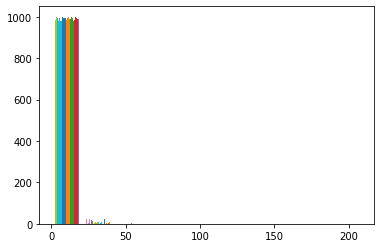

In [20]:
plt.hist(img[1][0:1000,0:1000].copy())
plt.show()

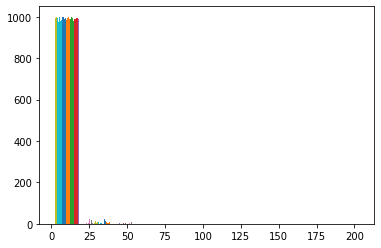

In [23]:
plt.hist(cv2.imread("delta_dev_branch/delta/training_tracking_n3/test_img/Position01Channe01Frame00000.png",cv2.IMREAD_GRAYSCALE))
plt.show()